In [1]:
import netCDF4
import keras

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import os, sys
import pandas as pd

- import **deephydro module** with networks, losses and metrics

In [3]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

#from deephydro.utils import limit_gpu_memory
#limit_gpu_memory()

# Data import

- paths

In [4]:
#os.chdir("/Users/schmidle/Documents/GIT-Projects/DeepHydro")
data_folder = '/ssd/deback/Data'
data_prec = '01_prec.nc'
data_temp = '01_temp.nc'
data_elev = 'dem/01_dem.nc'
data_disc = '01_discharge.csv'

- read output data

In [5]:
def read_output_data(data_folder:str, data_disc:str):
    # read csv file
    df = pd.read_csv(os.path.join(data_folder, data_disc))
    # calculate the difference to midsummer
    df['DOY'] = pd.DatetimeIndex(df['Time']).dayofyear
    # calculate the difference to midsummer
    df['DiffToMidSummer'] = pd.DatetimeIndex(df['Time']).dayofyear / 365
    return df

In [6]:
df = read_output_data(data_folder, data_disc)
df.head()

Unnamed: 0        Time      Q  DOY  DiffToMidSummer
0       27455  1950-01-01  558.0    1         0.002740
1       27456  1950-01-02  547.0    2         0.005479
2       27457  1950-01-03  541.0    3         0.008219
3       27458  1950-01-04  541.0    4         0.010959
4       27459  1950-01-05  564.0    5         0.013699

In [7]:
def plot_streamflow(df, n_labels=10):
    fig, ax = plt.subplots()
    ax.plot(df['Time'], df['Q'])
    ax.xaxis.set_major_locator(plt.MaxNLocator(n_labels)) # limit number of dates on x axis
    fig.autofmt_xdate() # rotate data labels
    plt.show()

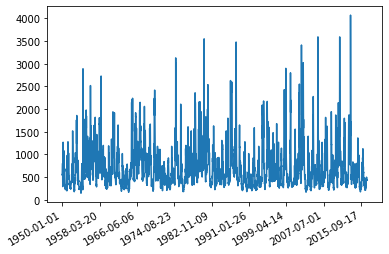

In [8]:
plot_streamflow(df)

- read input data (NetCDF4)

In [9]:
def read_data(filename, folder, varname):
    import netCDF4
    dat = netCDF4.Dataset(os.path.join(folder, filename))
    print(filename, dat.variables.keys())
    arr = np.array(dat.variables[varname])
    mask = arr < -100
    arr[ mask ] = 0.0
    return arr, mask[0]

def plot_frame(temp:np.array, prec:np.array, mask:np.array, df:pd.DataFrame, frame:int, limits:tuple=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    im_t = np.ma.masked_array(temp[frame], mask=mask)
    im_p = np.ma.masked_array(prec[frame], mask=mask)
    
    ax[0].set_title('Temperature')
    if limits is None:
        cb1 = ax[0].imshow(im_t)
    else:
        cb1 = ax[0].imshow(im_t, vmin=limits[0], vmax=limits[1])
    fig.colorbar(cb1, ax=ax[0], orientation='horizontal')

    ax[1].set_title('Precipitation')
    if limits is None:
        cb2 = ax[1].imshow(im_p)
    else:
        cb2 = ax[1].imshow(im_p, vmin=limits[2], vmax=limits[3])
    fig.colorbar(cb2, ax=ax[1], orientation='horizontal')
    
    for a in ax: a.axis('off')
        
    plt.show()


In [10]:
elev, mask = read_data(data_elev, data_folder, varname='dem')
temp, mask = read_data(data_temp, data_folder, varname='z (unknown)')
prec, mask = read_data(data_prec, data_folder, varname='z (unknown)')


dem/01_dem.nc odict_keys(['crs', 'longitude', 'latitude', 'dem'])
01_temp.nc odict_keys(['crs', 'longitude', 'latitude', 'z', 'z (unknown)'])
01_prec.nc odict_keys(['crs', 'longitude', 'latitude', 'z', 'z (unknown)'])


In [11]:
print(mask.shape)

(53, 66)


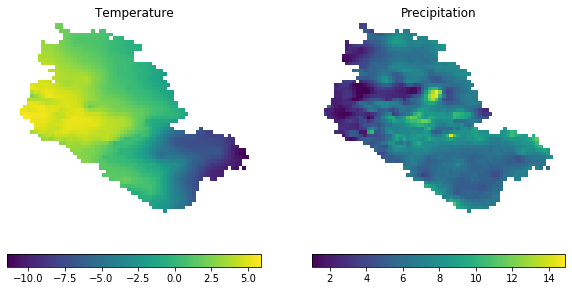

In [12]:
plot_frame(temp, prec, mask, df, frame=11)

# Data preparation

- standardize output data (`y`)

In [13]:
def standardize(data:np.array, return_moments=False):
    mean = np.mean(data)
    std = np.std(data)
    if return_moments:
        return (data-mean)/std, mean, std
    else:
        return (data-mean)/std

Y_MEAN = 704.088
Y_STD  = 439.004
Shape of y =  (24472,)


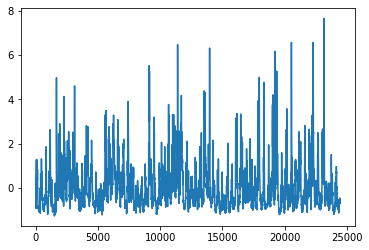

In [14]:
y, Y_MEAN, Y_STD = standardize(df['Q'].values, return_moments=True)
print(f'Y_MEAN = {Y_MEAN:.3f}')
print(f'Y_STD  = {Y_STD:.3f}')
print('Shape of y = ', y.shape)

# plot data
plt.plot(y)

- standardize and combine input image (`x`)

In [15]:
x_t = standardize(temp) #np.ma.masked_array(temp, mask=mask))
x_p = standardize(prec) #np.ma.masked_array(prec, mask=mask))
x = np.stack([x_t, x_p], axis=-1)
print('Shape of x = ', x.shape)

# plot sample frame
#plot_frame(x_t, x_p, mask, df, frame=11)

Shape of x =  (24472, 53, 66, 2)


- split train and test set
   - here: we don't use `train_test_split` anymore because we are dealing with sequences.
   - we simply take the first part as training data, and the last part as test data

# WARNING: ONLY USING 20% OF DATA

In [16]:
#x = x[:len(x)//5]
#y = y[:len(y)//5]

In [17]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)
train_size = int(0.80 * len(x))
x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

In [18]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_test  = ', x_test.shape)
print('Shape of y_test  = ', y_test.shape)


Shape of x_train =  (19577, 53, 66, 2)
Shape of y_train =  (19577,)
Shape of x_test  =  (4895, 53, 66, 2)
Shape of y_test  =  (4895,)


## Data generator

To sample image sequences, we do not store of all possible image sequences to memory. This would imply storing a lot of overlapping (=redundant) data.

Instead, we use a generator to generate a batch of random sequences. We could build a simple generator function using the `yield` statement, but to exploit parallel processing during batch generation, we will extend the `keras.utils.Sequence` class. 

In [19]:
# length of image sequence
n_frames = 30
# number of GPUs
n_gpus = 4
# adjust this to available GPU memory (VRAM)
batch_size = 12*n_gpus # 92*n_gpus

# use day of year ?
day_of_year = False
# forecasting ?
forecasting = False
# uncertainty estimation ?
uncertainty = False



In [20]:
from deephydro.generator import ImageSequenceGenerator
generator_train = ImageSequenceGenerator(data=x_train, labels=y_train, batch_size=batch_size, n_frames=n_frames)
generator_test  = ImageSequenceGenerator(data=x_test, labels=y_test, batch_size=batch_size, n_frames=n_frames)

In [21]:
batch = generator_train.__getitem__(0)
print(f'Shape of batch_x = {batch[0].shape}')
print(f'Shape of batch_y = {batch[1].shape}')


Shape of batch_x = (48, 30, 53, 66, 2)
Shape of batch_y = (48,)


In [22]:
#batch[0][0][1]

# Model

- load model
- predicts the streamflow from a short sequence of temperature and precipitation...

In [23]:
input_shape = (n_frames, *x_train.shape[1:])
from deephydro import networks
model = networks.nowcasting_model(input_shape, dayofyear=day_of_year)
#model = networks.get_conv_lstm_model(input_shape)
model.summary()

256
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 30, 53, 66, 2)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 30, 26, 32, 16)    10432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 26, 32, 16)    64        
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 30, 12, 15, 32)    55424     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 12, 15, 32)    128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 30, 5, 7, 64)      221440    
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 5, 7, 64)      

- compile model: loss, optimizer and metrics

In [24]:
from keras import optimizers
from deephydro.losses import mse, logcosh, gauss
from deephydro.metrics import ccc

def build_model(model, 
                loss=logcosh,
                metrics=ccc,
                optimizer=optimizers.Adam(lr=1e-3), 
                n_gpus:int=1):
    if n_gpus > 1:
        from keras.utils import multi_gpu_model
        parallel_model = multi_gpu_model(model, gpus=n_gpus)
        parallel_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return parallel_model
    else:
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return model


# Training

In [25]:
n_epochs = 20

In [26]:
from deephydro.utils import checkpointer, early_stopping, reduce_learning_rate
callbacks = [checkpointer('../output/model.h5'), early_stopping(), reduce_learning_rate()]

In [27]:
if n_gpus > 1:
    parallel_model = build_model(model, loss=logcosh, n_gpus=n_gpus)
    parallel_model.summary()
    history = parallel_model.fit_generator(
                              # training
                              generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              # validation
                              validation_data=generator_test,
                              validation_steps=len(x_test)//batch_size,
                              # callbacks
                              callbacks=callbacks,
                              # CPU parallelism 
                              #use_multiprocessing=False,
                              #workers=3, # if too large, you'll get CPU memory issues (job gets killed)
                              #max_queue_size=10
                              )
else:
    model = build_model(model, loss=logcosh, n_gpus=n_gpus)
    model.summary()
    history = model.fit_generator(
                              # training
                              generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              # validation
                              validation_data=generator_test,
                              validation_steps=len(x_test)//batch_size,
                              # callbacks
                              callbacks=callbacks,
                              # CPU parallelism 
                              #use_multiprocessing=False,
                              #workers=12,
                              #max_queue_size=10
                              )

InternalError: GPU sync failed

In [ ]:
from deephydro.visualization import plot_history
plot_history(history)

# Predict

In [ ]:
from deephydro.utils import predict
batch = generator_test.__getitem__(0)
im = batch[0][0]
gt = batch[1][0] * Y_STD + Y_MEAN
y_pred = predict(model, image=im, y_mean=Y_MEAN, y_std=Y_STD)
print(f'Predicted: {y_pred:.2f}, True: {gt:.2f}, Error: {abs(y_pred-gt):.2f}')

In [ ]:
from deephydro.utils import predict_batch
x, y = predict_batch(model, generator=generator_test, n_samples=5000, y_mean=Y_MEAN, y_std=Y_STD)

In [ ]:
from deephydro.visualization import plot_correlation
plot_correlation(x, y)

# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [ ]:
# get a batch of images
batch = generator_test.__getitem__(0)
# select a single image
im = batch[0][123]

In [ ]:
from deephydro.utils import saliency_map
shap = saliency_map(model, generator=generator_test, image=im)
print(shap.shape)

In [ ]:
from deephydro.visualization import plot_saliency_map
plot_saliency_map(image=im, shap_values=shap, mask=mask)